# Test Retinaface
* parse through RetinaFace to understand what its doing

In [1]:
%%bash
conda info | grep "active environment"

     active environment : abh1


In [2]:
import sys
import os
import os.path as osp
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torchvision
torch.__version__

'1.6.0.dev20200605'

In [3]:
_retinapath = osp.abspath("..")
if _retinapath not in sys.path:
    sys.path.append(_retinapath)

from models.retinaface import RetinaFace
from data.config import *
from runutils import *
from layers.functions.prior_box import PriorBox
from utils.box_utils import decode, decode_landm

In [4]:
_wpath = osp.abspath("../weights")
weights = {"resnet50":osp.join(_wpath,"Resnet50_Final.pth"),
            "mobilenet0.25":osp.join(_wpath, "mobilenet0.25_Final.pth")}
for _w in weights.values():
    assert osp.isfile(_w), "%s not found"%_w
    
configs = {"resnet50":cfg_re50, "mobilenet0.25":cfg_mnet}
print(configs)
print(weights)

{'resnet50': {'name': 'Resnet50', 'min_sizes': [[16, 32], [64, 128], [256, 512]], 'steps': [8, 16, 32], 'variance': [0.1, 0.2], 'clip': False, 'loc_weight': 2.0, 'gpu_train': True, 'batch_size': 24, 'ngpu': 4, 'epoch': 100, 'decay1': 70, 'decay2': 90, 'image_size': 840, 'pretrain': True, 'return_layers': {'layer2': 1, 'layer3': 2, 'layer4': 3}, 'in_channel': 256, 'out_channel': 256}, 'mobilenet0.25': {'name': 'mobilenet0.25', 'min_sizes': [[16, 32], [64, 128], [256, 512]], 'steps': [8, 16, 32], 'variance': [0.1, 0.2], 'clip': False, 'loc_weight': 2.0, 'gpu_train': True, 'batch_size': 32, 'ngpu': 1, 'epoch': 250, 'decay1': 190, 'decay2': 220, 'image_size': 640, 'pretrain': True, 'return_layers': {'stage1': 1, 'stage2': 2, 'stage3': 3}, 'in_channel': 32, 'out_channel': 64}}
{'resnet50': '/home/z/work/gits/Face/RetinaFace/Pytorch_Retinaface/weights/Resnet50_Final.pth', 'mobilenet0.25': '/home/z/work/gits/Face/RetinaFace/Pytorch_Retinaface/weights/mobilenet0.25_Final.pth'}


### test setup

In [5]:
_net = "resnet50" #"mobilenet0.25"
device = "cuda"
cudnn.benchmark = True

In [6]:
def showboxes(image, bboxes, landms=None, max_boxes=5000, max_break=None, show=False):
    _mod = len(bboxes)//max_boxes + 1
    
    if max_break is not None:
        _mod = 1

    if show:
        plt.figure(figsize=(15, 15))
    plt.imshow(Image.open(image))
    cmap = plt.cm.get_cmap("hsv", len(bboxes))
    _j = 0
    for _i, _b in enumerate(bboxes):
        if max_break is not None and _i >= max_break:
            break
        if _j >= max_boxes:
            break 

        if not _i%_mod:
            _h = _b[2] - _b[0]
            _w = _b[3] - _b[1]
            _p = plt.Rectangle((_b[0], _b[1]), _h, _w, fill=False,
                               color=cmap(np.random.randint(0, len(bboxes))))
            plt.gca().add_patch(_p)
            if landms is not None and len(landms) > 0:
                scatter(landms[_i])
            _j+=1
    if show:
        plt.show()

def scatter(landms):
    _landms = landms.reshape(5,2).T
    plt.scatter(_landms[0], _landms[1])

In [7]:
imname = '/home/z/work/gits/Face/Face_Detection_Alignment/image/725392d3eac55aba65c2c3d24c29c2b7.jpg'

In [8]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
img_raw = cv2.imread(imname, cv2.IMREAD_COLOR)
img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

In [9]:

r = lambda x: round(x.item(), 2)

_printtensor = lambda x, xname: print(xname, "\t", x.dtype, x.device, " grad", x.requires_grad,
                                      " contiguous", x.is_contiguous(), "", x.shape,
                                      r(x.min()), r(x.max()), r(x.mean()), r(x.std()))
_printlongtensor = lambda x, xname: print(xname, "\t", x.dtype, x.device, " grad", x.requires_grad,
                                      " contiguous", x.is_contiguous(), "", x.shape,
                                      r(x.min()), r(x.max()))
_printarray = lambda x, xname: print(xname, "\t", x.dtype, "\t", x.shape, "\tcontiguous",
                                    x.flags['C_CONTIGUOUS'])


def detect(imname, weights, config, device="cuda", resize=1, threshold=0.02, nms_threshold=0.4,
           topk=5000, debug=True, showpriors=False, backend=None):
    #backend ='pil'
    

    center = (123, 117, 104)
    if backend is not None and backend[0].lower() == "c":
            center = (104, 117, 123)
    
    img = open_tensor(imname, dtype="float32", device="cuda", normed=False,
                      center=(104, 117, 123), backend=backend, debug=False)
    _w = img.shape[3]
    _h = img.shape[2]
    scale = torch.Tensor([_w, _h]).to(device=device).div_(resize)
    if debug:
        print(scale, "scale")
        _printtensor(img, "img")

    with torch.no_grad():
        net = RetinaFace(cfg=config, phase='test')
#         print (net)
        net = load_model(net, pretrained_path=weights, device=device, verbose=debug).eval().to(device)
        if debug:
            print("imsum", img.sum().item())
            print("netsum", sum([p.sum().item() for p in net.parameters()]))
        loc, conf, landms = net(img)
        
        if debug:
            print("loc  ", loc[:,-1])
            print("conf ", conf[:,-1])
            print("landms", landms[:,-1])
            _printtensor(conf, "conf")
            _printtensor(landms, "landms")
    
        priorbox = PriorBox(cfg=config, image_size=(_h, _w))
        priors = priorbox.forward().to(device=device)
      
        scores = conf.clone().detach().squeeze(0)[:, 1].contiguous()

        boxes = decode(loc.squeeze(0), priors, config["variance"])
        landms = decode_landm(landms.squeeze(0), priors, config['variance'])
        
        if debug:
            _printtensor(loc, "loc")
            _printtensor(conf, "conf")
            _printtensor(landms, "landms")
            print("Priorbox\n", priorbox.__dict__)
            _printtensor(priors, "\npriors")
            _printtensor(boxes, "boxes")
            _printtensor(scores, "scores")
            _printtensor(landms, "landms")
        
        # rescale shape
        _shape = boxes.shape
        boxes.view(_shape[0], -1, 2).mul_(scale).view(*_shape)
        _shape = landms.shape
        landms.view(_shape[0], -1, 2).mul_(scale).view(*_shape)
        
        if debug:
            _printtensor(boxes, "_boxes")
            _printtensor(landms, "_landm")

        if showpriors:
            plt.figure(figsize=(20,20))
            plt.subplot(1,3,1)
            max_boxes=400
            max_break=None#1000
            plt.title("sample of %d from %d boxes"%(max_boxes, len(boxes)))
            showboxes(imname, boxes, max_boxes=max_boxes, max_break=max_break, show=False)#max_break=100)

        # ignore low scores
        inds = torch.where(scores > threshold)[0]
        boxes = boxes[inds]
        landms = landms[inds]
        scores = scores[inds]
        # argsort
        order = scores.argsort(descending=True)
        boxes = boxes[order]
        landms = landms[order]
        scores = scores[order]
        
        if debug:
            print(landms.dtype)
            print(landms.shape)
            _printtensor(landms, "_landm")
            _printtensor(scores, "scores")
            _printtensor(boxes, "boxes")
        
        if showpriors:
            plt.subplot(1,3,2)
            plt.title("threshold > %.3f, %d detections"%(threshold, len(boxes)))
            showboxes(imname, boxes, show=False)
        
        # non maximum suppresion
        keep = torchvision.ops.nms(boxes, scores, nms_threshold)
        boxes = boxes[keep,:]
        landms = landms[keep,:]
        
        if debug:
            _printlongtensor(keep, "nms:keep")
            _printtensor(boxes, "nms:boxes")
            _printtensor(landms, "nms:landms")
        
        if showpriors:
            plt.subplot(1,3,3)
            plt.title("nms with threshold: %.3f, %d detections"%(nms_threshold, len(boxes)))
            showboxes(imname, boxes, landms.cpu().clone().detach().numpy(), max_boxes=50, show=False)
            plt.show()


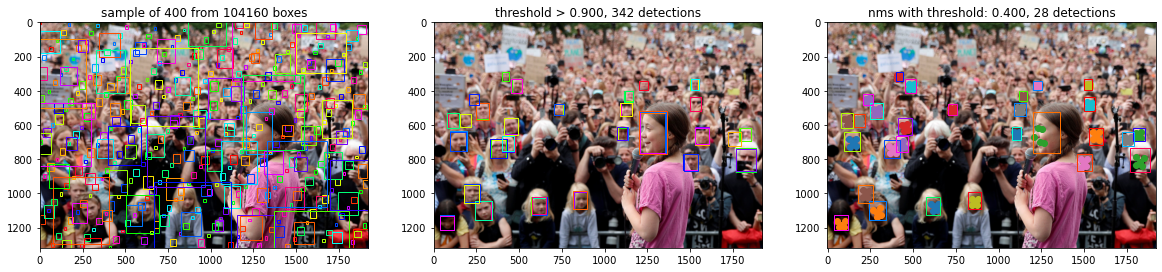

In [10]:
img = "/media/z/Malatesta/data/Self/Multitudes/comic-con-and-climate-protest-fridays-best-photos_img-7.jpg"
showpriors=True
debug=True
ff=detect(img, weights=weights[_net], config=configs[_net], device="cuda:0", threshold=0.9,
          debug=False, showpriors=showpriors)

### Oddness from NMS in RetinaFace: It culls some of the more important faces

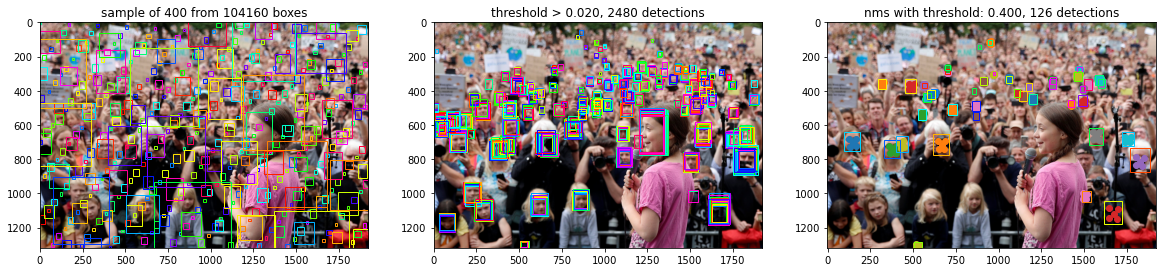

In [11]:
showpriors=True
debug=True
ff=detect(img, weights=weights[_net], config=configs[_net], device="cuda:0", threshold=0.02,
          debug=False, showpriors=showpriors)

## Try different opening backends, pil accimage cv2.  why are they different

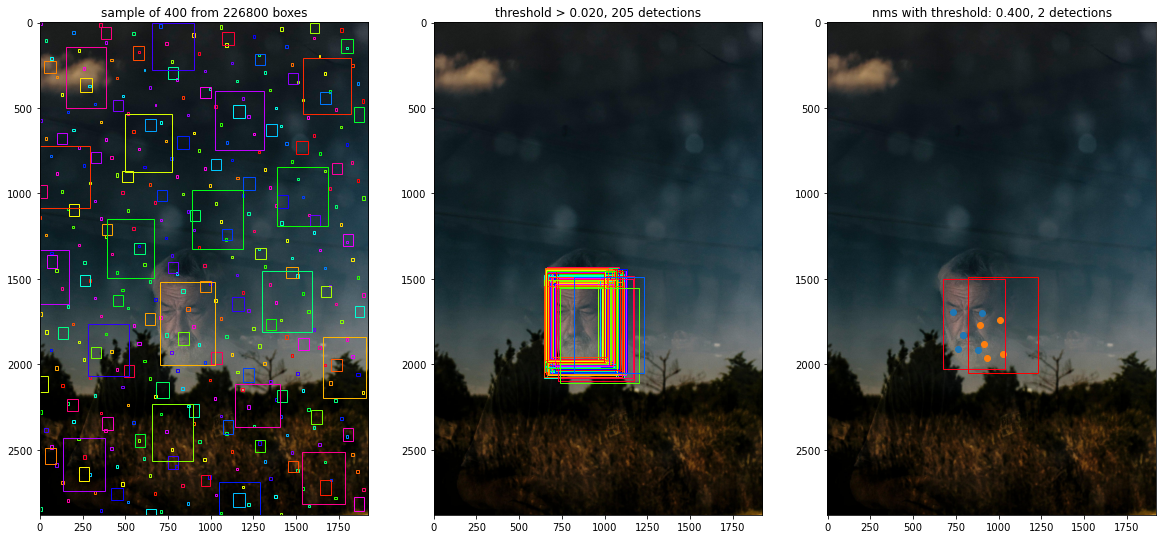

In [12]:
showpriors=True
debug=True
ff=detect(imname, weights=weights[_net], config=configs[_net], device="cuda:0", threshold=0.02,
          debug=False, showpriors=showpriors,  backend="pil")

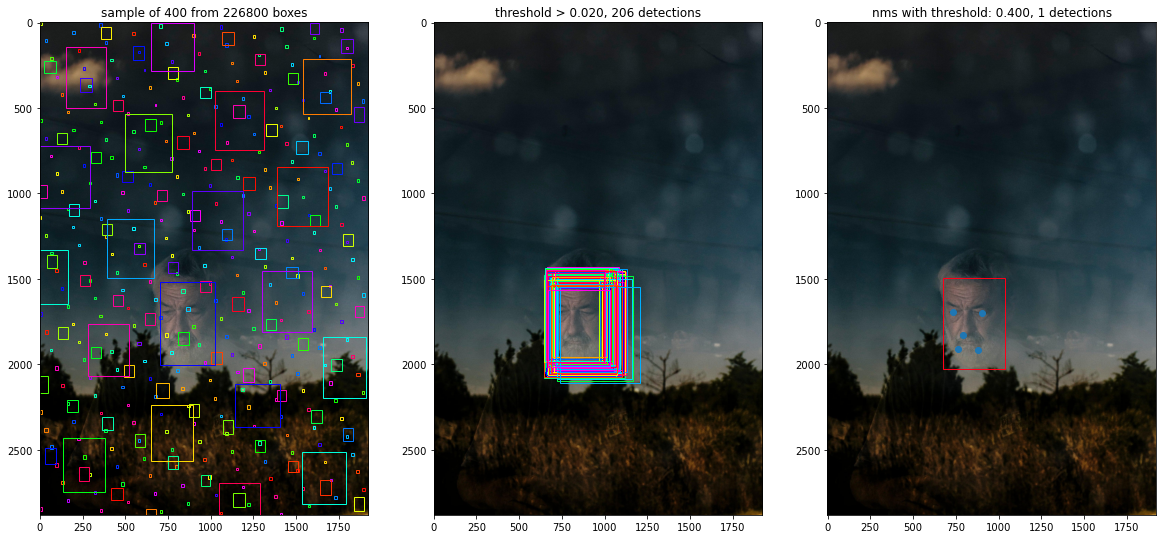

In [13]:
showpriors=True
ff=detect(imname, weights=weights[_net], config=configs[_net], device="cuda:0", threshold=0.02,
          debug=False, showpriors=showpriors)

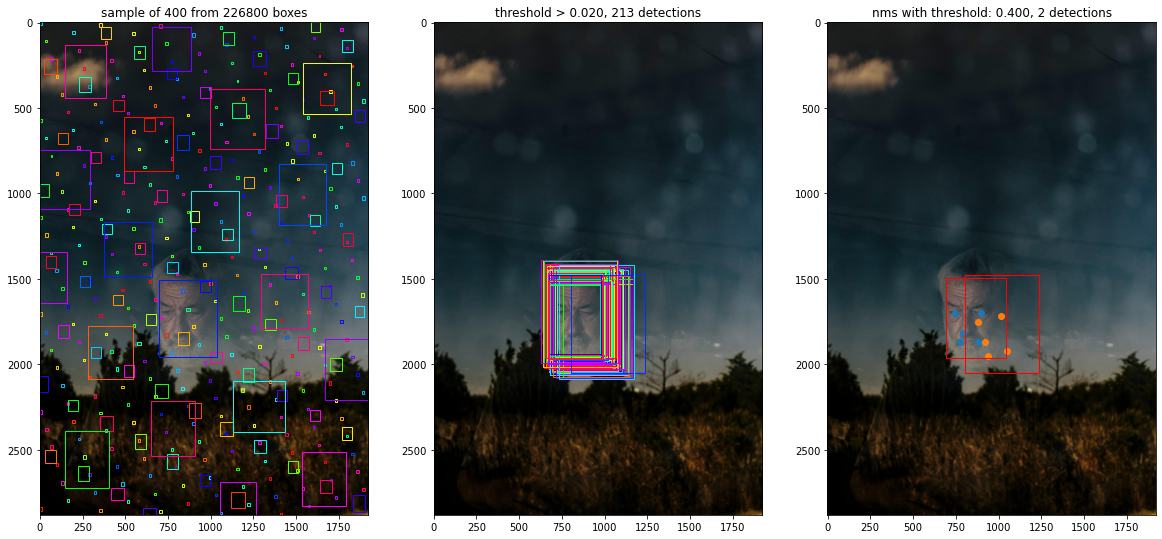

In [14]:
showpriors=True
debug=True
ff=detect(imname, weights=weights[_net], config=configs[_net], device="cuda:0", threshold=0.02,
          debug=False, showpriors=showpriors,  backend="cv2")

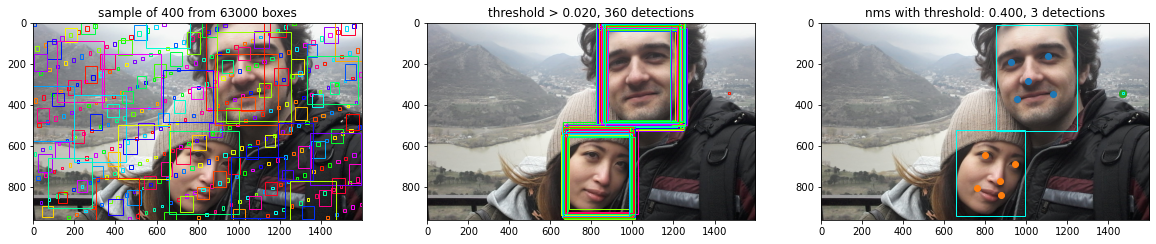

In [15]:
img = "/media/z/Malatesta/data/Self/Multitudes/how-we-met-i-took-a-good-look-at-his-photo-to-see-whether-he-might-be-sleazy_img-1.jpg"
ff=detect(img, weights=weights[_net], config=configs[_net], device="cuda:0", threshold=0.02,
              debug=False, showpriors=True)

In [13]:
def get_files(folder, types=(".png", ".jpg"), force=False, val=False):
    root = osp.split(folder)[0]
    fname = folder+".txt"
    out = []
    if osp.isfile(fname) and not force:
        with open(fname, 'r') as fi:
            out = fi.read().split("\n")
        print("found", fname, "num imgs:", len(out))
        if val:
            for f in out:
                if not osp.isfile(f):
                    out = []
                    break
    if not out:
        for root, folders, files in os.walk(folder):
            out += [osp.join(root,f) for f in files if f[-4:] in types]
        with open(fname, 'w') as fi:
            fi.write("\n".join(out))
        print("collected", fname, "num imgs:", len(out))
    return out

found /media/z/Malatesta/data/Self/Multitudes.txt num imgs: 7490
/media/z/Malatesta/data/Self/Multitudes/new-hampshire-joe-biden-campaign#img-1_new-hampshire-joe-biden-campaign_img-1.jpg


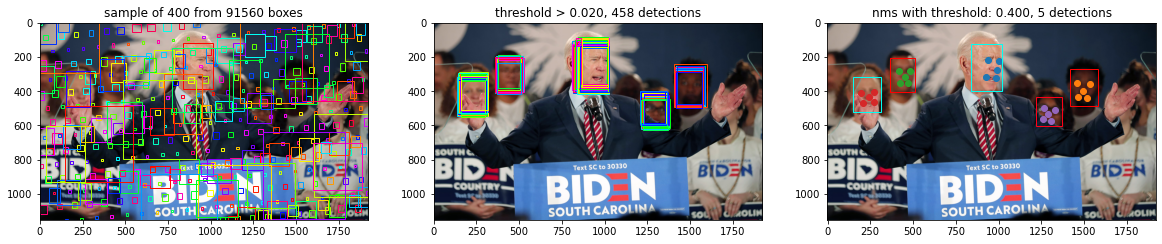

/media/z/Malatesta/data/Self/Multitudes/sleater-kinney-where-to-start-in-their-back-catalogue#img-1_sleater-kinney-where-to-start-in-their-back-catalogue_img-1.jpg


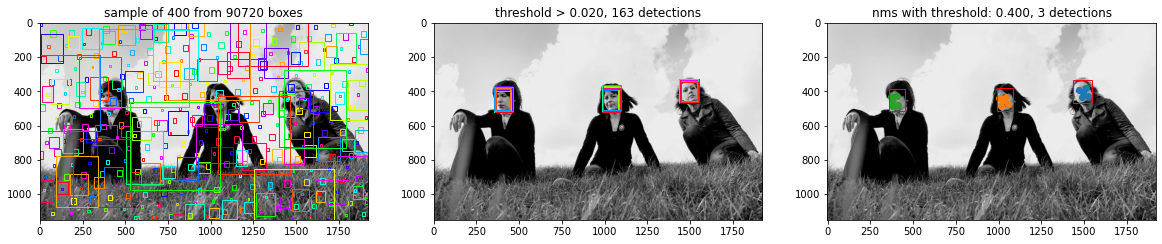

/media/z/Malatesta/data/Self/Multitudes/the-birth-of-the-teenager-from-teds-to-punks-to-hip-hop-in-picture_5.jpg


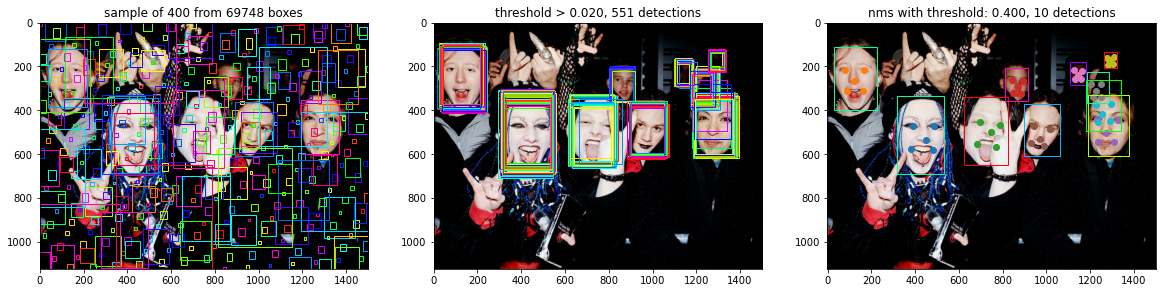

/media/z/Malatesta/data/Self/Multitudes/chaos-hope-change-stories-from-70-years-of-the-peoples-republic-of-china_img-12.jpg


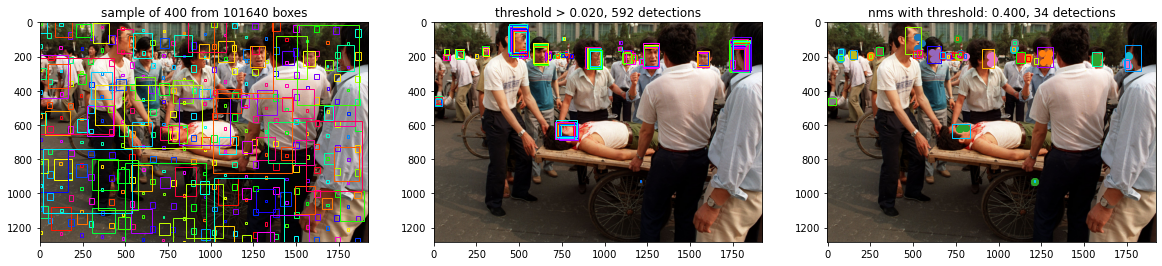

/media/z/Malatesta/data/Self/Multitudes/cuba_churches_reject_gay.jpg


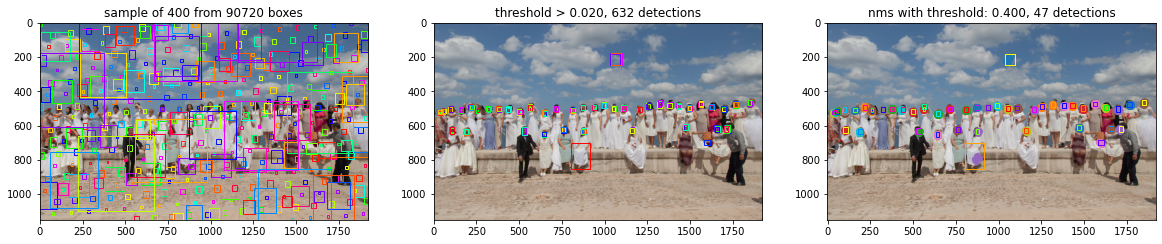

/media/z/Malatesta/data/Self/Multitudes/ethiopia_crash_report2.jpg


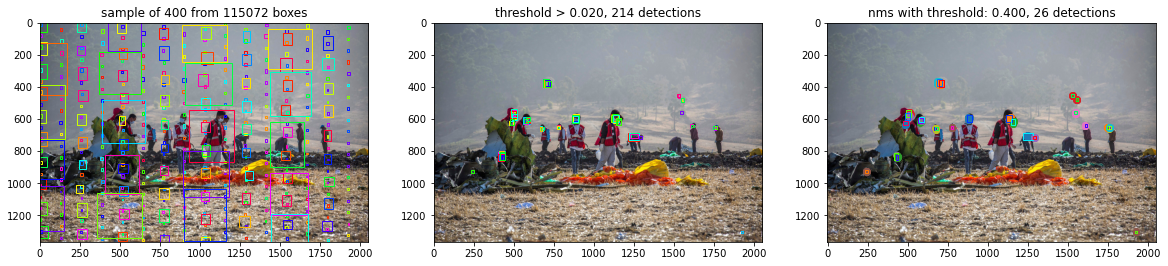

/media/z/Malatesta/data/Self/Multitudes/heavy-rain-landslides-flooding-mass-evacuations-brazil#img-3_heavy-rain-landslides-flooding-mass-evacuations-brazil_img-3.jpg


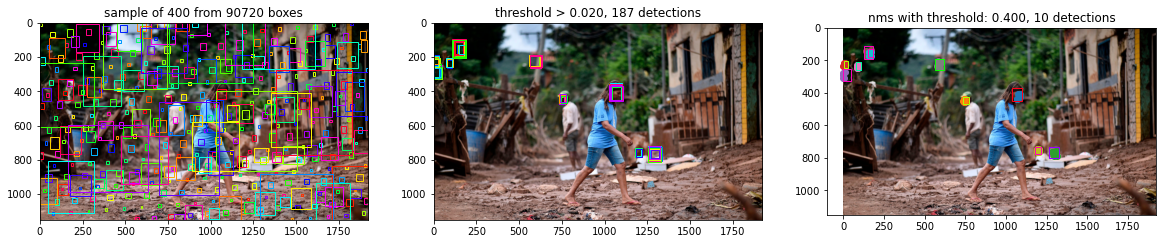

/media/z/Malatesta/data/Self/Multitudes/dementia-sex-consent-care-home_img-1.jpg


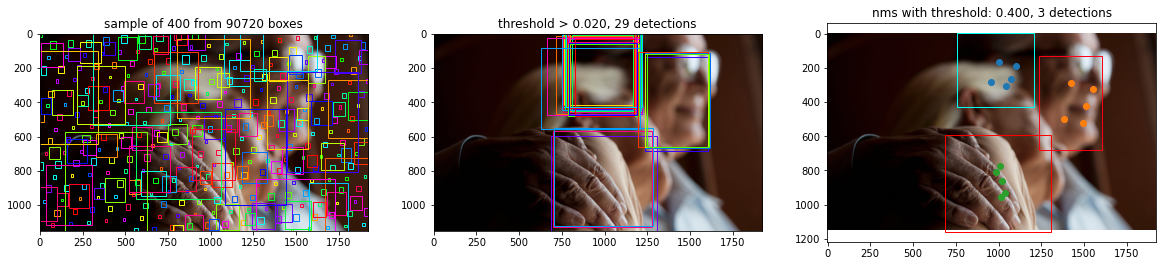

/media/z/Malatesta/data/Self/Multitudes/volodymyr-zelenskiy-after-the-landslide-things-get-serious-for-servant-of-ukrainian-people.jpg


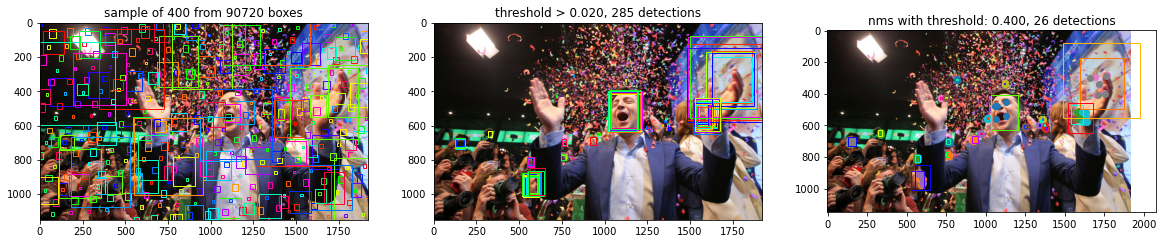

/media/z/Malatesta/data/Self/Multitudes/mozambique_water.jpg


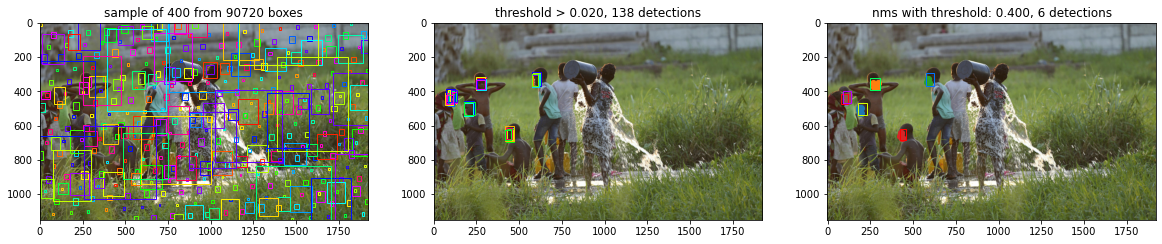

In [14]:
files = get_files("/media/z/Malatesta/data/Self/Multitudes")
for i in range(10):
    img = files[random.randint(0,len(files)-1)]
    print(img)
    showpriors=True
    ff=detect(img, weights=weights[_net], config=configs[_net], device="cuda:0", threshold=0.02,
              debug=False, showpriors=showpriors)